# Lesson 7: Classification

In [3]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn. naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None  # default='warn'


We will use Kaggle Titanic data to demonstrate these major steps.

* Data: https://www.kaggle.com/competitions/titanic/data
* Examples used to compose this notebook: https://www.kaggle.com/code/startupsci/titanic-data-science-solutions, https://www.kaggle.com/code/abhishekmamidi/titanic-data-preprocessing-and-visualization/notebook

In [4]:
PATH = "../../data/titanic"
df = pd.read_csv(os.path.join(PATH, "train.csv"), index_col=0)
df.head()





,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
df.drop(["Cabin"], axis=1, inplace=True)  # too many missing values
df.dropna(subset=["Embarked"], inplace=True)  # only 2 missing values

df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S


In [7]:
# train-test-split
df_train, df_test = train_test_split(df, test_size=0.15, random_state=42, shuffle=True)
combine = [df_train, df_test]

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,3,"Nilsson, Miss. Helmina Josefina",female,26.0,0,0,347470,7.8542,S
1,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,S
2,0,3,"Johansson, Mr. Karl Johan",male,31.0,0,0,347063,7.7750,S
3,1,2,"Brown, Miss. Amelia ""Mildred""",female,24.0,0,0,248733,13.0000,S
4,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.0,1,0,349237,17.8000,S


In [8]:
# perform data preprocessing separately on each of the datasets:
# 1. converting male and female to binary (0 and 1)
# 2. imputing age based on median value for given class and sex
# 3. converting embarked in S t0 0, C to 1 and Q to 2

for dataset in combine:
    # convert categorical features to numeric
    dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1}).astype(int)
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    # fill missging values for age
    guess_ages = np.zeros((2, 3))
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            guess_ages[i, j] = int(guess_df.median())
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) & (dataset.Sex ==i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i, j]
            
    dataset['Age'] = dataset['Age'].astype(int)

In [9]:
for dataset in combine:
    dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  755 non-null    int64  
 1   Pclass    755 non-null    int64  
 2   Name      755 non-null    object 
 3   Sex       755 non-null    int64  
 4   Age       755 non-null    int64  
 5   SibSp     755 non-null    int64  
 6   Parch     755 non-null    int64  
 7   Ticket    755 non-null    object 
 8   Fare      755 non-null    float64
 9   Embarked  755 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 59.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  134 non-null    int64  
 1   Pclass    134 non-null    int64  
 2   Name      134 non-null    object 
 3   Sex       134 non-null    int64  
 4   Age       134 non-nu

In [10]:
# drop columns that are irrelevant for prediction

for dataset in combine:
    dataset.drop("Name", axis=1, inplace=True)
    dataset.drop("Ticket", axis=1, inplace=True)

<Axes: xlabel='Age', ylabel='Pclass'>

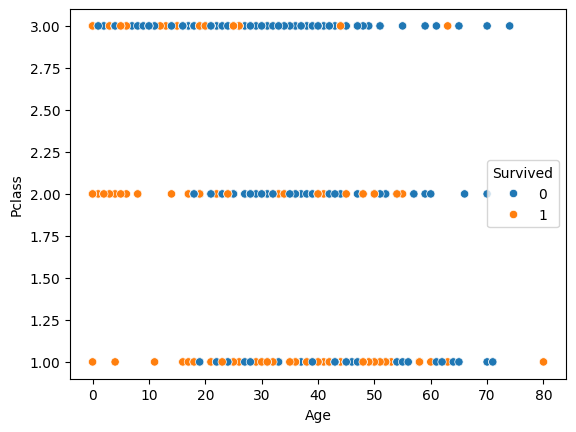

In [11]:
sns.scatterplot(x='Age', y='Pclass', hue="Survived", data=df_train[["Age", "Pclass", "Survived"]])
#sns.lineplot(x= np.array([2.0, 44.0]), y = np.array([3.0, 1.0]))
#sns.lineplot(x= np.array([2.0, 61.0]), y = np.array([3.0, 1.0]))

In [12]:
# create features
X_train = df_train[["Age", "Pclass"]]
y_train = df_train["Survived"]
X_test = df_test[["Age", "Pclass"]]
y_test = df_test["Survived"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((755, 2), (755,), (134, 2), (134,))

# Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [13]:
model = LogisticRegression() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc_log = round(model.score(X_train, y_train)*100, 2)
acc_log
# score - відсоток правильних відповідей

69.4

In [14]:
model.coef_, model.intercept_ # intercept - bias

(array([[-0.0464081 , -1.19343869]]), array([3.60349275]))

In [15]:
model.intercept_.item()

3.6034927455698957

In [16]:
# f(x_1, x_2)  = 0

# x_1*model.coef_[0][0] + x_2*model.coef_[0][1] + model.intercept_.item() = 0
# x_1*model.coef_[0][0] + x_2*model.coef_[0][1] = - model.intercept_.item()

# when x_1 = 0:
# x_2*1.19343869 - 3.60349275 = 0
#
x_2_when_x_1_0 = 3.60349275/1.19343869
x_2_when_x_1_0

3.0194200843279178

In [17]:
# when x_2=0
# x_1*0.0464081 = -3.60349275/0.0464081
x_1_when_x_2_0 = -3.60349275/-0.0464081
x_1_when_x_2_0

77.64792676278495

<Axes: xlabel='Age', ylabel='Pclass'>

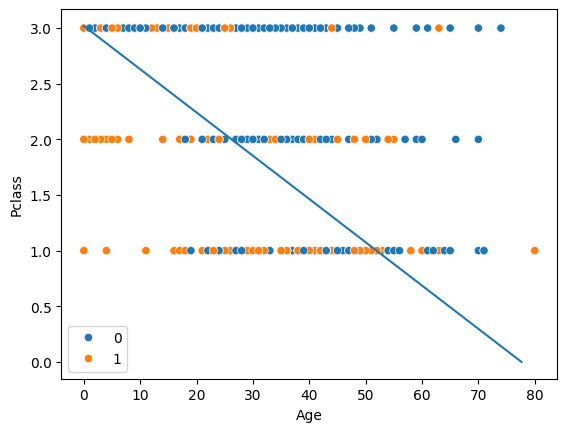

In [18]:
sns.scatterplot(x='Age', y='Pclass', hue="Survived", data=df_train[["Age", "Pclass", "Survived"]])
sns.lineplot(x= np.array([0.0, x_1_when_x_2_0]), y = np.array([x_2_when_x_1_0, 0.0]))
#sns.lineplot(x= np.array([2.0, x_1_when_x_2_0]), y = np.array([3.0, 1.0]))
#sns.lineplot(x= np.array([x_2_when_x_1_0, 61.0]), y = np.array([3.0, 1.0]))

In [19]:
coef_df = pd.DataFrame(X_train.columns)
coef_df.columns = ['Feature']
coef_df["Correlation"] = pd.Series(model.coef_[0])

coef_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
0,Age,-0.046408
1,Pclass,-1.193439


In [20]:
# add more features
X_train_df = df_train.drop("Survived", axis=1)
X_train = X_train_df.to_numpy()
y_train = df_train["Survived"]
X_test_df = df_test.drop("Survived", axis=1)
X_test = X_test_df.to_numpy()
y_test = df_test["Survived"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((755, 7), (755,), (134, 7), (134,))

In [21]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc_log = round(model.score(X_train, y_train)*100, 2)
acc_log

80.4

x1 * model.coef_[0][0] + x_2*model.coef_[0][1] + x_3* model.coef_[0][2] + .... + model.intercept_.item() = 0

In [22]:
coeff_df = pd.DataFrame(X_train_df.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(model.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.539042
6,Embarked,0.196484
5,Fare,0.001283
4,Parch,-0.043163
2,Age,-0.047143
3,SibSp,-0.365092
0,Pclass,-1.247458


In [23]:
for feature_name, feature, in zip(X_test_df.columns, X_test[0]):
    print(feature_name, feature)

Pclass 3.0
Sex 0.0
Age 28.0
SibSp 0.0
Parch 0.0
Fare 7.8542
Embarked 0.0


In [24]:
model.predict(X_test)

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0])

In [25]:
for feature_name, feature in zip(X_test_df.columns, X_test[1]):
    print(feature_name, feature)

Pclass 1.0
Sex 1.0
Age 14.0
SibSp 1.0
Parch 2.0
Fare 120.0
Embarked 0.0


In [26]:
model.predict_proba(X_test)

array([[0.89928566, 0.10071434],
       [0.03927268, 0.96072732],
       [0.30038278, 0.69961722],
       [0.73682616, 0.26317384],
       [0.03482767, 0.96517233],
       [0.8950408 , 0.1049592 ],
       [0.68865112, 0.31134888],
       [0.86509541, 0.13490459],
       [0.09564956, 0.90435044],
       [0.04422009, 0.95577991],
       [0.58730775, 0.41269225],
       [0.45425995, 0.54574005],
       [0.96354832, 0.03645168],
       [0.90509496, 0.09490504],
       [0.90329333, 0.09670667],
       [0.89756747, 0.10243253],
       [0.68431016, 0.31568984],
       [0.86981727, 0.13018273],
       [0.77862032, 0.22137968],
       [0.89041357, 0.10958643],
       [0.72035505, 0.27964495],
       [0.05909464, 0.94090536],
       [0.9474384 , 0.0525616 ],
       [0.4624614 , 0.5375386 ],
       [0.89039426, 0.10960574],
       [0.50953277, 0.49046723],
       [0.75325965, 0.24674035],
       [0.09289528, 0.90710472],
       [0.50680137, 0.49319863],
       [0.69934326, 0.30065674],
       [0.

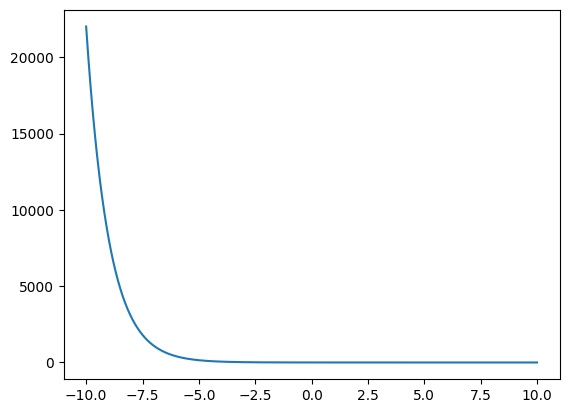

In [27]:
x = np.linspace(-10, 10, 100000)
y = math.e**(-x)

fig = plt.figure()
# Create the plot
plt.plot(x, y)

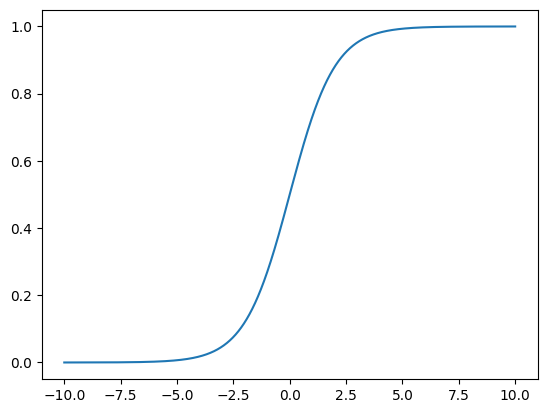

In [28]:
x = np.linspace(-10, 10, 100000)
y = 1 / (1 + np.exp(-x))

fig = plt.figure()

plt.plot(x,y)

In [29]:
# y = 1 /(math.e**-1 + 1)
y = 1 /(math.e**0 + 1)

y


0.5

In [30]:
# Loss function

probs = model.predict_proba(X_test)
probs

array([[0.89928566, 0.10071434],
       [0.03927268, 0.96072732],
       [0.30038278, 0.69961722],
       [0.73682616, 0.26317384],
       [0.03482767, 0.96517233],
       [0.8950408 , 0.1049592 ],
       [0.68865112, 0.31134888],
       [0.86509541, 0.13490459],
       [0.09564956, 0.90435044],
       [0.04422009, 0.95577991],
       [0.58730775, 0.41269225],
       [0.45425995, 0.54574005],
       [0.96354832, 0.03645168],
       [0.90509496, 0.09490504],
       [0.90329333, 0.09670667],
       [0.89756747, 0.10243253],
       [0.68431016, 0.31568984],
       [0.86981727, 0.13018273],
       [0.77862032, 0.22137968],
       [0.89041357, 0.10958643],
       [0.72035505, 0.27964495],
       [0.05909464, 0.94090536],
       [0.9474384 , 0.0525616 ],
       [0.4624614 , 0.5375386 ],
       [0.89039426, 0.10960574],
       [0.50953277, 0.49046723],
       [0.75325965, 0.24674035],
       [0.09289528, 0.90710472],
       [0.50680137, 0.49319863],
       [0.69934326, 0.30065674],
       [0.

In [31]:
probs_1 = probs[:, 1]

probs_1

array([0.10071434, 0.96072732, 0.69961722, 0.26317384, 0.96517233,
       0.1049592 , 0.31134888, 0.13490459, 0.90435044, 0.95577991,
       0.41269225, 0.54574005, 0.03645168, 0.09490504, 0.09670667,
       0.10243253, 0.31568984, 0.13018273, 0.22137968, 0.10958643,
       0.27964495, 0.94090536, 0.0525616 , 0.5375386 , 0.10960574,
       0.49046723, 0.24674035, 0.90710472, 0.49319863, 0.30065674,
       0.58445375, 0.74508476, 0.10960574, 0.54149361, 0.03671903,
       0.39515131, 0.70511993, 0.69413619, 0.13039844, 0.10960574,
       0.14589765, 0.53149795, 0.33191553, 0.10958643, 0.51168225,
       0.49151902, 0.78692816, 0.11901706, 0.22826916, 0.90622607,
       0.92584019, 0.76260582, 0.12937145, 0.11527558, 0.90687989,
       0.88541763, 0.4280246 , 0.06251478, 0.16495068, 0.26255214,
       0.33664176, 0.48747155, 0.77798254, 0.16500076, 0.83858352,
       0.38608057, 0.03819108, 0.106511  , 0.90122795, 0.96472137,
       0.29150057, 0.97819079, 0.68984109, 0.10516283, 0.40606

In [32]:
condition = probs_1 > 0.5
# pbobability of survival for surviving group
probs_1[condition]


array([0.96072732, 0.69961722, 0.96517233, 0.90435044, 0.95577991,
       0.54574005, 0.94090536, 0.5375386 , 0.90710472, 0.58445375,
       0.74508476, 0.54149361, 0.70511993, 0.69413619, 0.53149795,
       0.51168225, 0.78692816, 0.90622607, 0.92584019, 0.76260582,
       0.90687989, 0.88541763, 0.77798254, 0.83858352, 0.90122795,
       0.96472137, 0.97819079, 0.68984109, 0.78313935, 0.82282995,
       0.57123256, 0.95150332, 0.8796265 , 0.74508476, 0.65365285,
       0.70048295, 0.97528925, 0.52237954, 0.59795796, 0.96794392,
       0.68262775, 0.90080556, 0.56497387, 0.94584747, 0.96110203,
       0.93619711, 0.5375386 , 0.88315366, 0.74508476, 0.82540998])

In [33]:
# probability of survival for non-surviving group
# ~ - negation

probs_1[~condition]

array([0.10071434, 0.26317384, 0.1049592 , 0.31134888, 0.13490459,
       0.41269225, 0.03645168, 0.09490504, 0.09670667, 0.10243253,
       0.31568984, 0.13018273, 0.22137968, 0.10958643, 0.27964495,
       0.0525616 , 0.10960574, 0.49046723, 0.24674035, 0.49319863,
       0.30065674, 0.10960574, 0.03671903, 0.39515131, 0.13039844,
       0.10960574, 0.14589765, 0.33191553, 0.10958643, 0.49151902,
       0.11901706, 0.22826916, 0.12937145, 0.11527558, 0.4280246 ,
       0.06251478, 0.16495068, 0.26255214, 0.33664176, 0.48747155,
       0.16500076, 0.38608057, 0.03819108, 0.106511  , 0.29150057,
       0.10516283, 0.40606487, 0.1462111 , 0.07445062, 0.38892334,
       0.17179843, 0.15417923, 0.05469636, 0.33191553, 0.11418805,
       0.10960574, 0.08861603, 0.12929258, 0.08127632, 0.11582248,
       0.10958643, 0.21952061, 0.18817388, 0.15417923, 0.11416209,
       0.08492532, 0.07301102, 0.0523412 , 0.15306306, 0.13487026,
       0.14068526, 0.04367728, 0.11231762, 0.10658253, 0.10342

In [34]:
# pfrobability of non-survival for non-surviving group
1 - probs_1[~condition]

array([0.89928566, 0.73682616, 0.8950408 , 0.68865112, 0.86509541,
       0.58730775, 0.96354832, 0.90509496, 0.90329333, 0.89756747,
       0.68431016, 0.86981727, 0.77862032, 0.89041357, 0.72035505,
       0.9474384 , 0.89039426, 0.50953277, 0.75325965, 0.50680137,
       0.69934326, 0.89039426, 0.96328097, 0.60484869, 0.86960156,
       0.89039426, 0.85410235, 0.66808447, 0.89041357, 0.50848098,
       0.88098294, 0.77173084, 0.87062855, 0.88472442, 0.5719754 ,
       0.93748522, 0.83504932, 0.73744786, 0.66335824, 0.51252845,
       0.83499924, 0.61391943, 0.96180892, 0.893489  , 0.70849943,
       0.89483717, 0.59393513, 0.8537889 , 0.92554938, 0.61107666,
       0.82820157, 0.84582077, 0.94530364, 0.66808447, 0.88581195,
       0.89039426, 0.91138397, 0.87070742, 0.91872368, 0.88417752,
       0.89041357, 0.78047939, 0.81182612, 0.84582077, 0.88583791,
       0.91507468, 0.92698898, 0.9476588 , 0.84693694, 0.86512974,
       0.85931474, 0.95632272, 0.88768238, 0.89341747, 0.89657

In [35]:
# probability of survival for survinvg group * probability of non-survival for non-surviving group
(np.prod(probs_1[condition])) * (np.prod(1 - probs_1[~condition]))

np.float64(1.5201684534966957e-14)

In [36]:
-(np.sum(np.log(probs_1[condition])) + np.sum(np.log(1 - probs_1[~condition])))

np.float64(31.817370148530177)

In [37]:
y_test_array = y_test.to_numpy()
y_test_array

array([0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0])

In [38]:
# rewrite the formula
-np.sum(y_test_array * np.log(probs)[:,1] + (1 - y_test_array) * (np.log(1 - (probs)[:,1])))

np.float64(56.359244266121074)

In [39]:
-np.sum(y_test_array * np.log(probs)[:,1] + (1 - y_test_array) * np.log(probs)[:,0]) / len(probs) # normalized


np.float64(0.42059137512030653)

In [40]:
from sklearn.metrics import log_loss
log_loss(y_test, probs) # , normalize=False

0.42059137512030653

In [41]:
(1 - y_test.to_numpy())*(1-np.log(probs)[:,1])

array([3.29546705, 0.        , 0.        , 2.33494048, 0.        ,
       0.        , 2.16684119, 3.00318752, 0.        , 0.        ,
       1.88505311, 0.        , 4.31176772, 3.35487843, 3.33607295,
       3.27855095, 2.15299507, 3.0388162 , 2.50787603, 3.21104176,
       2.27423452, 0.        , 3.94576945, 1.62075471, 3.21086555,
       1.71239682, 2.39941873, 0.        , 1.70684329, 2.20178608,
       0.        , 0.        , 3.21086555, 1.61342401, 4.30446006,
       1.92848652, 0.        , 0.        , 3.03716056, 3.21086555,
       2.92484996, 1.63205593, 2.10287477, 3.21104176, 0.        ,
       0.        , 1.23961832, 3.12848844, 2.47722982, 0.        ,
       0.        , 0.        , 3.04506753, 3.1604297 , 0.        ,
       0.        , 1.84857461, 3.77235221, 2.80210878, 2.33730558,
       0.        , 1.71852334, 0.        , 2.80180518, 0.        ,
       1.9517092 , 4.26515325, 3.23950703, 0.        , 0.        ,
       2.23271332, 1.02205055, 1.37129401, 0.        , 0.     

# Other classification models

In [42]:
# Stochastic Gradient Descent

sgd = SGDClassifier(loss='log_loss') # Logistic Regression
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train)*100, 2)
acc_sgd
# score - відсоток правильних відповідей классифікатора SGD

62.38

In [ ]:
# Логістична похибка

probs_sgd = sgd.predict_proba(X_test)
log_loss(y_test, probs_sgd)

11.849589449658549

In [44]:
# Gradient Descent calculation example
x = np.linspace(0, 10, 1000)
dx = x[1]-x[0]
y = x**2 +1
dydx = np.gradient(y, dx)
dydx

array([1.00100100e-02, 2.00200200e-02, 4.00400400e-02, 6.00600601e-02,
       8.00800801e-02, 1.00100100e-01, 1.20120120e-01, 1.40140140e-01,
       1.60160160e-01, 1.80180180e-01, 2.00200200e-01, 2.20220220e-01,
       2.40240240e-01, 2.60260260e-01, 2.80280280e-01, 3.00300300e-01,
       3.20320320e-01, 3.40340340e-01, 3.60360360e-01, 3.80380380e-01,
       4.00400400e-01, 4.20420420e-01, 4.40440440e-01, 4.60460460e-01,
       4.80480480e-01, 5.00500501e-01, 5.20520521e-01, 5.40540541e-01,
       5.60560561e-01, 5.80580581e-01, 6.00600601e-01, 6.20620621e-01,
       6.40640641e-01, 6.60660661e-01, 6.80680681e-01, 7.00700701e-01,
       7.20720721e-01, 7.40740741e-01, 7.60760761e-01, 7.80780781e-01,
       8.00800801e-01, 8.20820821e-01, 8.40840841e-01, 8.60860861e-01,
       8.80880881e-01, 9.00900901e-01, 9.20920921e-01, 9.40940941e-01,
       9.60960961e-01, 9.80980981e-01, 1.00100100e+00, 1.02102102e+00,
       1.04104104e+00, 1.06106106e+00, 1.08108108e+00, 1.10110110e+00,
      

In [45]:
(0.0003/len(dydx))*np.sum(dydx)

np.float64(0.003)

In [46]:
#RidgeClassifier
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)
Y_pred = ridge.predict(X_test)
acc_ridge = round(ridge.score(X_train, y_train)*100, 2)
acc_ridge


79.87

# Multi-class classifiction

In [47]:
# Стратегія "один проти всіх"
from sklearn.multiclass import OneVsRestClassifier
# create features
X_train = df_train[["Age", "Survived"]]
y_train = df_train["Pclass"]
X_test = df_test[["Age", "Survived"]]
y_test = df_test["Pclass"]

clf = OneVsRestClassifier(LogisticRegression(random_state=0)).fit(X_train, y_train)
preds_3 = clf.predict(X_test)
preds_3

array([3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3,
       3, 3])

In [48]:
y_test.to_numpy()

array([3, 1, 3, 2, 1, 3, 2, 3, 1, 1, 2, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 1,
       3, 1, 3, 1, 2, 2, 1, 2, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 2, 3, 2, 3,
       1, 1, 2, 3, 2, 1, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 1, 3, 2, 2,
       3, 3, 1, 1, 2, 1, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 2, 3, 2, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3, 2, 3, 3, 1, 3, 3,
       3, 1, 3, 1, 3, 3, 2, 2, 3, 3, 2, 1, 3, 3, 1, 1, 1, 1, 3, 1, 2, 2,
       2, 3])

In [49]:
"Train", clf.score(X_train, y_train), "Test", clf.score(X_test, y_test)

('Train', 0.6556291390728477, 'Test', 0.6119402985074627)

In [50]:
# Стратегія один проти одного

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

clf = OneVsOneClassifier(
    LogisticRegression(random_state=0)).fit(X_train, y_train)

preds_3 = clf.predict(X_test)
preds_3

array([3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3,
       3, 3])

In [51]:
"Train", clf.score(X_train, y_train), "Test", clf.score(X_test, y_test)

('Train', 0.6569536423841059, 'Test', 0.6119402985074627)